sss

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

In [5]:
def create_combined_model(seq_length=33, struct_features=12, struct_window=0):
    """Create model with both sequence and structure tracks
    
    Args:
        seq_length: length of the input sequence
        struct_features: number of structural features
        struct_window: number of positions to use around middle (0 = only middle position)
    """
    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)  # center + window on each side
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    
    # Structure track
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    # Extract window around middle position
    if struct_window == 0:
        # Use only middle position
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos:middle_pos+1, :]
        )(struct_input)
    else:
        # Use window around middle position
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos-struct_window:middle_pos+struct_window+1, :]
        )(struct_input)
    
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(32, activation='relu')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    
    # Combine tracks
    combined = tf.keras.layers.Concatenate()([x_seq, x_struct])
    
    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=[seq_input, struct_input], outputs=outputs)

In [6]:
def train_and_evaluate(struct_window=0):
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_data_train_after.csv")
    test_df = pd.read_csv("../data/processed_data_test_after.csv")
    
    # Prepare data
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Shuffle data
    train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df['label'].value_counts())
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_struct])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
        
    return model

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5094 - loss: 0.7065 - val_accuracy: 0.5311 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5451 - loss: 0.6843 - val_accuracy: 0.6537 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6449 - loss: 0.6354 - val_accuracy: 0.7000 - val_loss: 0.6013 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6889 - loss: 0.5938 - val_accuracy: 0.7119 - val_loss: 0.5675 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7212 - loss: 0.5688 - val_accuracy: 0.7192 - val_loss: 0.5587 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7283 - loss: 0.5498 - val_accuracy: 0.7203 - val_loss: 0.5502 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7386 - loss: 0.5406 - val_

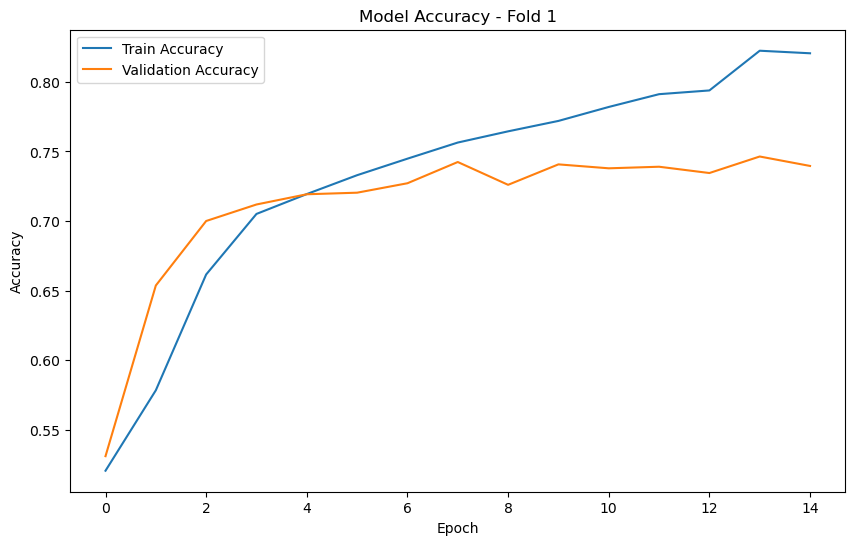

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 1 Results:
Accuracy: 0.7407
Balanced Accuracy: 0.7382
MCC: 0.4834
Sensitivity: 0.8171
Specificity: 0.6593

Fold 2/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5032 - loss: 0.7161 - val_accuracy: 0.5571 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5377 - loss: 0.6901 - val_accuracy: 0.6418 - val_loss: 0.6375 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6228 - loss: 0.6417 - val_accuracy: 0.6893 - val_loss: 0.5863 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6909 - loss: 0.5824 - val_accuracy: 0.7282 - val_loss: 0.5482 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7250 - loss: 0.5510 - val_accuracy: 0.7475 - val_loss: 0.5240 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7281 - loss: 0.5370 - val_accuracy: 0.7537 - val_loss: 0.5191 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7488 - loss: 0.

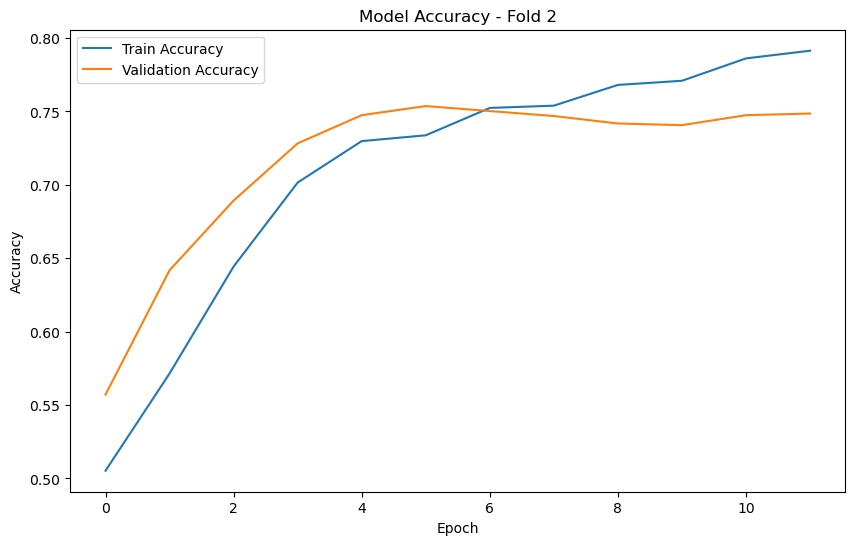

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2 Results:
Accuracy: 0.7503
Balanced Accuracy: 0.7478
MCC: 0.4981
Sensitivity: 0.7906
Specificity: 0.7050

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5027 - loss: 0.7086 - val_accuracy: 0.5294 - val_loss: 0.6861 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5879 - loss: 0.6694 - val_accuracy: 0.6678 - val_loss: 0.6263 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6644 - loss: 0.6229 - val_accuracy: 0.6859 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7048 - loss: 0.5648 - val_accuracy: 0.7249 - val_loss: 0.5604 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7356 - loss: 0.5342 - val_accuracy: 0.7288 - val_loss: 0.5552 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7575 - loss: 0.5104 - val_accuracy: 0.7367 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7597 - loss: 0.4875 - val_

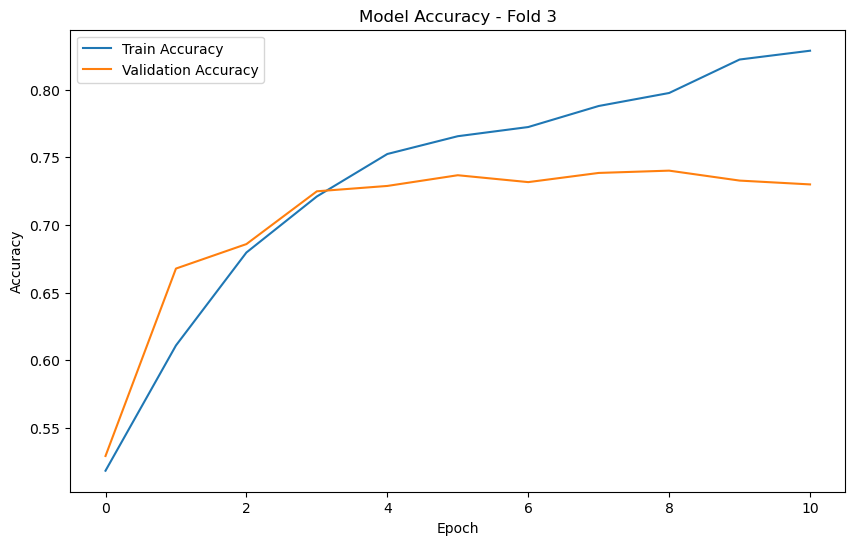

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 3 Results:
Accuracy: 0.7367
Balanced Accuracy: 0.7372
MCC: 0.4742
Sensitivity: 0.7229
Specificity: 0.7515

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5110 - loss: 0.7131 - val_accuracy: 0.5486 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5067 - loss: 0.6983 - val_accuracy: 0.5684 - val_loss: 0.6845 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5684 - loss: 0.6723 - val_accuracy: 0.6989 - val_loss: 0.5950 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6974 - loss: 0.5833 - val_accuracy: 0.7266 - val_loss: 0.5535 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7239 - loss: 0.5534 - val_accuracy: 0.7367 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7477 - loss: 0.5214 - val_accuracy: 0.7373 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7592 - loss: 0.5117 - val_

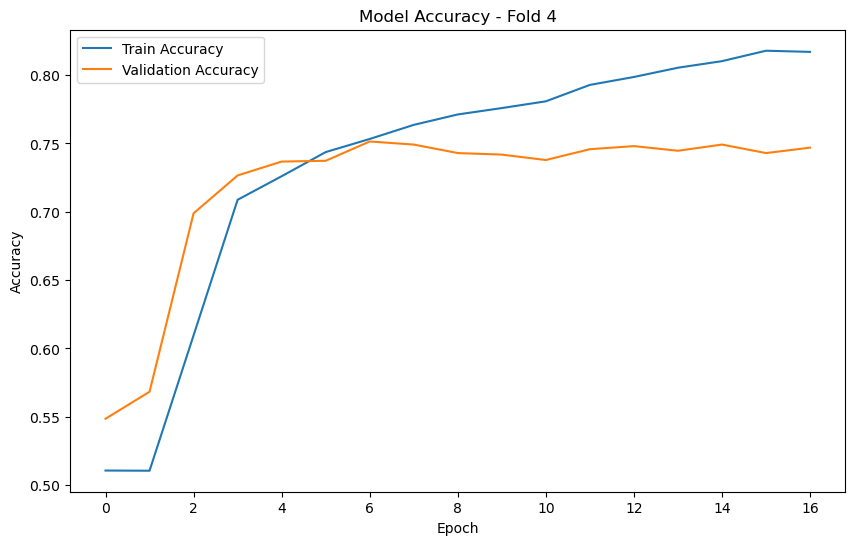

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Results:
Accuracy: 0.7458
Balanced Accuracy: 0.7439
MCC: 0.4919
Sensitivity: 0.8018
Specificity: 0.6861

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5089 - loss: 0.7065 - val_accuracy: 0.5141 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5346 - loss: 0.6877 - val_accuracy: 0.6147 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6272 - loss: 0.6422 - val_accuracy: 0.6785 - val_loss: 0.6012 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7001 - loss: 0.5798 - val_accuracy: 0.7028 - val_loss: 0.5592 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7310 - loss: 0.5392 - val_accuracy: 0.7328 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7498 - loss: 0.5119 - val_accuracy: 0.7282 - val_loss: 0.5328 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7613 - loss: 0.5002 - val_

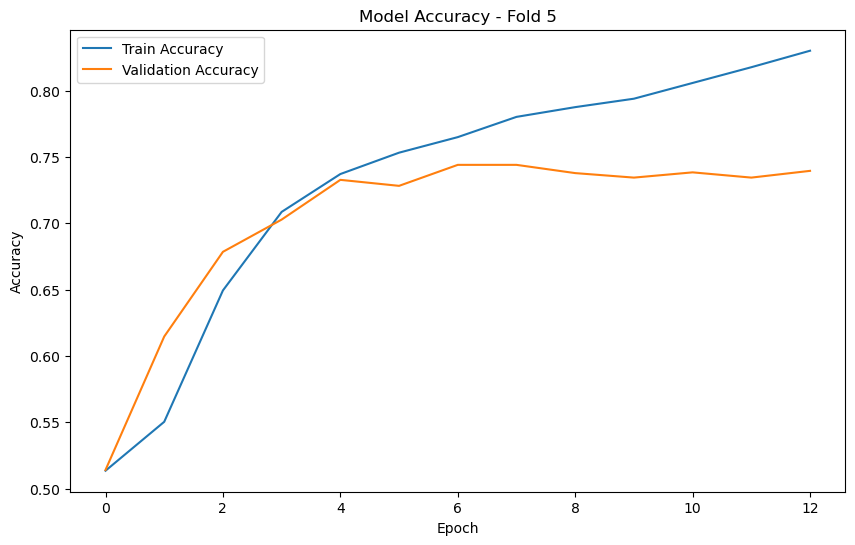

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5 Results:
Accuracy: 0.7441
Balanced Accuracy: 0.7426
MCC: 0.4872
Sensitivity: 0.7819
Specificity: 0.7034

Average Cross-validation Results:
ACC: 0.7435 ± 0.0046
BALANCED_ACC: 0.7420 ± 0.0039
MCC: 0.4869 ± 0.0081
SN: 0.7828 ± 0.0322
SP: 0.7011 ± 0.0301

Final Test Set Results:
Accuracy: 0.7128
Balanced Accuracy: 0.7353
MCC: 0.2824
Sensitivity: 0.7625
Specificity: 0.7080
Confusion Matrix:
[[1768  729]
 [  57  183]]


In [24]:
if __name__ == "__main__":
    model = train_and_evaluate()

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-03 12:27:33.469475: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-03 12:27:33.469501: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-03 12:27:33.469510: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-03 12:27:33.469531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 12:27:33.469547: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-03 12:27:34.507172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5168 - loss: 0.7166 - val_accuracy: 0.5706 - val_loss: 0.6777 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5745 - loss: 0.6757 - val_accuracy: 0.6599 - val_loss: 0.6323 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6563 - loss: 0.6276 - val_accuracy: 0.6842 - val_loss: 0.6086 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6785 - loss: 0.5995 - val_accuracy: 0.7062 - val_loss: 0.5810 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7152 - loss: 0.5678 - val_accuracy: 0.7305 - val_loss: 0.5385 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7348 - loss: 0.5401 - val_accuracy: 0.7266 - val_loss: 0.5284 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7555 - loss: 0.5139 - val

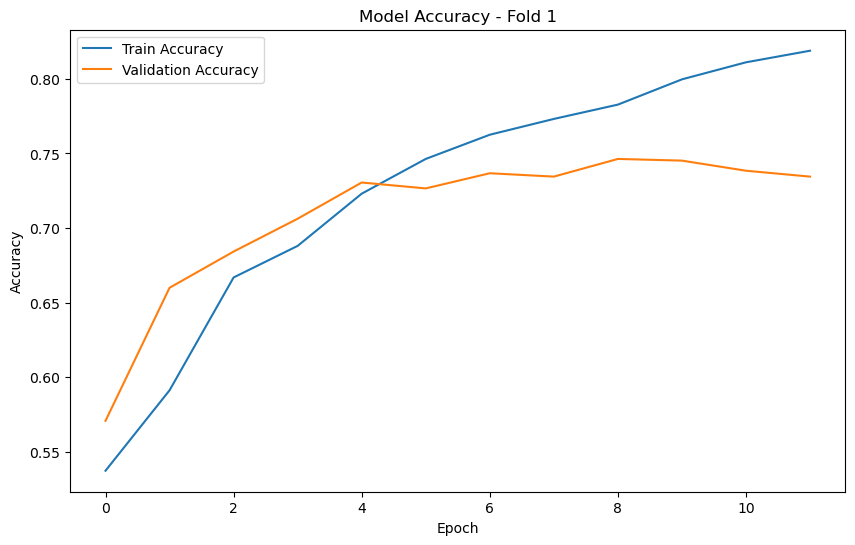

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7367
Balanced Accuracy: 0.7346
MCC: 0.4744
Sensitivity: 0.8028
Specificity: 0.6663

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.5111 - loss: 0.7090 - val_accuracy: 0.5881 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5701 - loss: 0.6775 - val_accuracy: 0.6565 - val_loss: 0.6189 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6678 - loss: 0.6097 - val_accuracy: 0.7164 - val_loss: 0.5544 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7260 - loss: 0.5543 - val_accuracy: 0.7463 - val_loss: 0.5223 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7374 - loss: 0.5303 - val_accuracy: 0.7593 - val_loss: 0.5075 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7561 - loss: 0.5107 - val_accuracy: 0.7593 - val_loss: 0.5029 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7707 - loss: 0.4870 - val

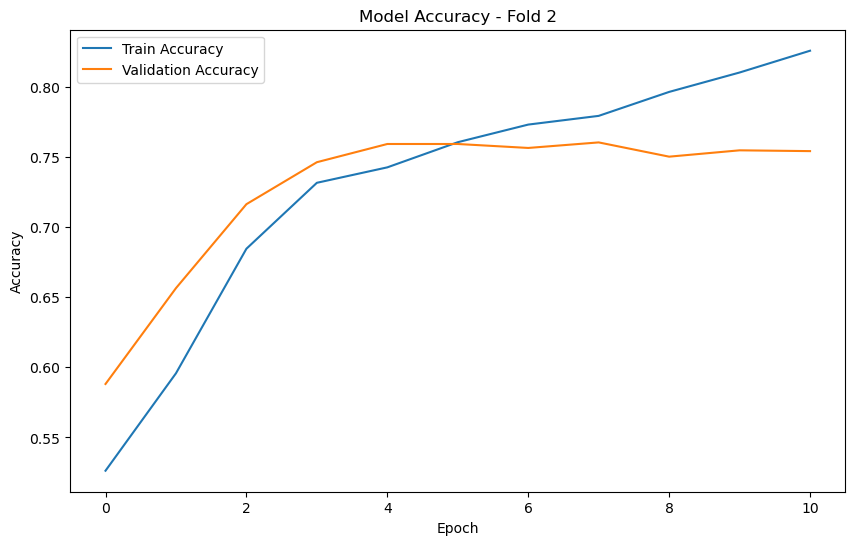

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2 Results:
Accuracy: 0.7593
Balanced Accuracy: 0.7574
MCC: 0.5164
Sensitivity: 0.7906
Specificity: 0.7242

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.5142 - loss: 0.7155 - val_accuracy: 0.5401 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5621 - loss: 0.6807 - val_accuracy: 0.6367 - val_loss: 0.6506 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6351 - loss: 0.6370 - val_accuracy: 0.7023 - val_loss: 0.5806 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7157 - loss: 0.5636 - val_accuracy: 0.7356 - val_loss: 0.5492 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7314 - loss: 0.5420 - val_accuracy: 0.7305 - val_loss: 0.5485 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7496 - loss: 0.5256 - val_accuracy: 0.7384 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7601 - loss: 0.5093 - val_

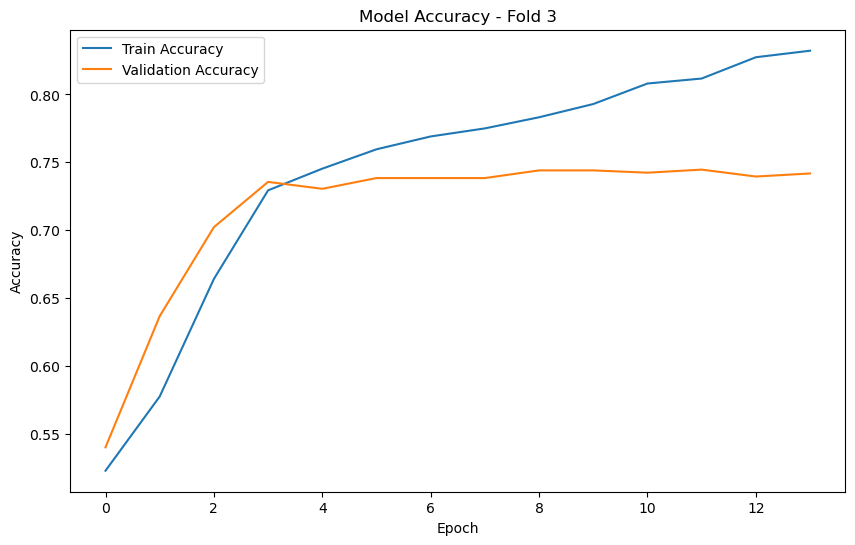

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7441
Balanced Accuracy: 0.7421
MCC: 0.4887
Sensitivity: 0.8039
Specificity: 0.6803

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5307 - loss: 0.7258 - val_accuracy: 0.5684 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5580 - loss: 0.6817 - val_accuracy: 0.6576 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6467 - loss: 0.6328 - val_accuracy: 0.6949 - val_loss: 0.5917 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7023 - loss: 0.5806 - val_accuracy: 0.7299 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7315 - loss: 0.5406 - val_accuracy: 0.7203 - val_loss: 0.5434 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7462 - loss: 0.5166 - val_accuracy: 0.7345 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7641 - loss: 0.4987 - val_

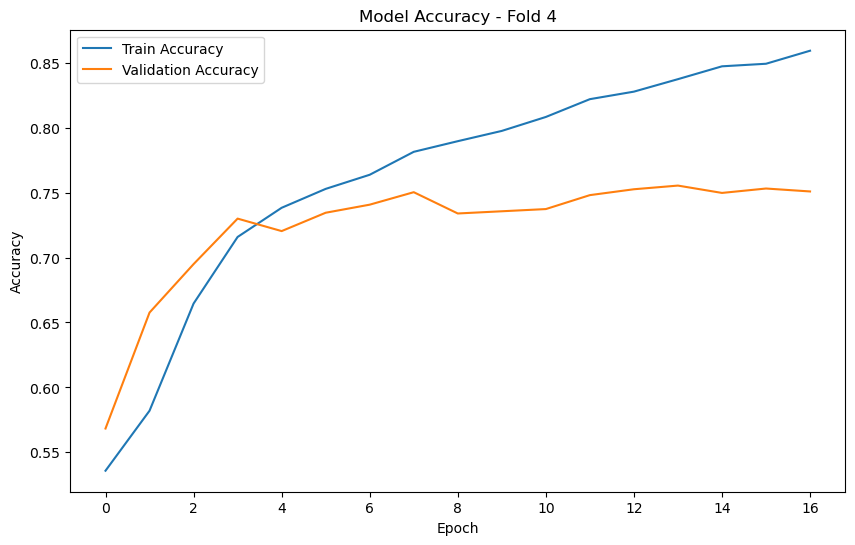

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 4 Results:
Accuracy: 0.7480
Balanced Accuracy: 0.7456
MCC: 0.4981
Sensitivity: 0.8226
Specificity: 0.6686

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5268 - loss: 0.7121 - val_accuracy: 0.5938 - val_loss: 0.6793 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6137 - loss: 0.6574 - val_accuracy: 0.6548 - val_loss: 0.6182 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6705 - loss: 0.6110 - val_accuracy: 0.7124 - val_loss: 0.5714 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7212 - loss: 0.5605 - val_accuracy: 0.7254 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7346 - loss: 0.5379 - val_accuracy: 0.7401 - val_loss: 0.5296 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7522 - loss: 0.5120 - val_accuracy: 0.7390 - val_loss: 0.5246 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7676 - loss: 0.4994 - val

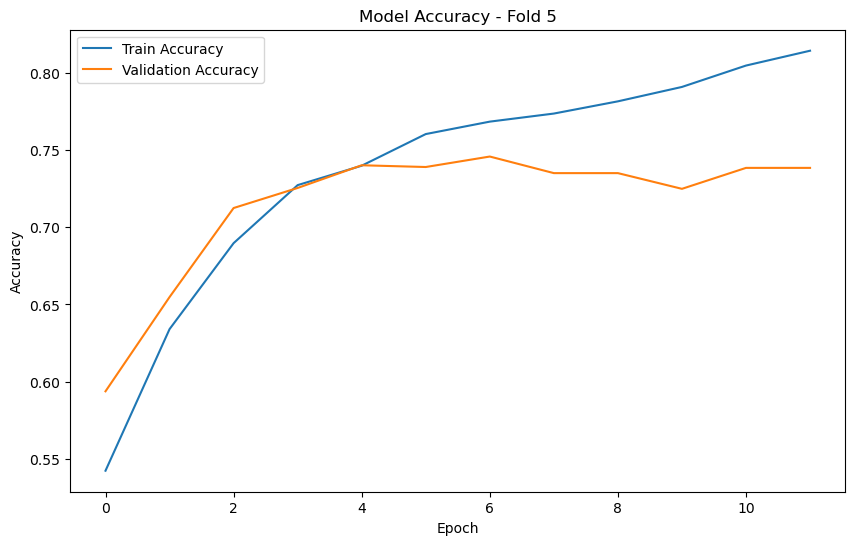

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5 Results:
Accuracy: 0.7458
Balanced Accuracy: 0.7456
MCC: 0.4910
Sensitivity: 0.7514
Specificity: 0.7397

Average Cross-validation Results:
ACC: 0.7468 ± 0.0073
BALANCED_ACC: 0.7450 ± 0.0074
MCC: 0.4937 ± 0.0137
SN: 0.7943 ± 0.0238
SP: 0.6958 ± 0.0303

Final Test Set Results:
Accuracy: 0.6997
Balanced Accuracy: 0.7375
MCC: 0.2816
Sensitivity: 0.7833
Specificity: 0.6916
Confusion Matrix:
[[1727  770]
 [  52  188]]


<Functional name=functional_9, built=True>

In [7]:
train_and_evaluate(struct_window=1)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5155 - loss: 0.7261 - val_accuracy: 0.5514 - val_loss: 0.6853 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5527 - loss: 0.6830 - val_accuracy: 0.5797 - val_loss: 0.6708 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5765 - loss: 0.6750 - val_accuracy: 0.6198 - val_loss: 0.6510 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5994 - loss: 0.6597 - val_accuracy: 0.6633 - val_loss: 0.6238 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6514 - loss: 0.6253 - val_accuracy: 0.6831 - val_loss: 0.5997 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6715 - loss: 0.6029 - val_accuracy: 0.6972 - val_loss: 0.5872 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6878 - loss: 0.5905 - val

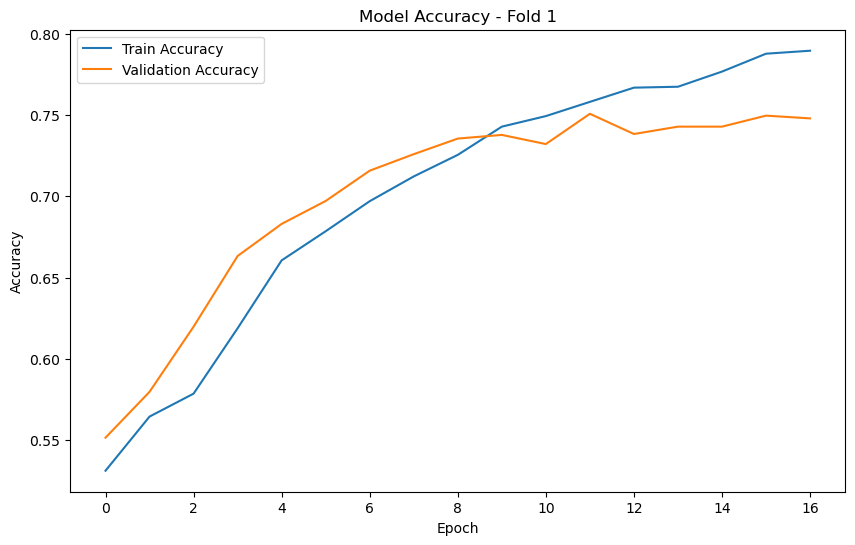

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 1 Results:
Accuracy: 0.7508
Balanced Accuracy: 0.7489
MCC: 0.5024
Sensitivity: 0.8105
Specificity: 0.6873

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5346 - loss: 0.7007 - val_accuracy: 0.5678 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5658 - loss: 0.6777 - val_accuracy: 0.6260 - val_loss: 0.6523 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6311 - loss: 0.6430 - val_accuracy: 0.6898 - val_loss: 0.5851 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7040 - loss: 0.5799 - val_accuracy: 0.7328 - val_loss: 0.5384 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7328 - loss: 0.5495 - val_accuracy: 0.7514 - val_loss: 0.5266 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7333 - loss: 0.5286 - val_accuracy: 0.7650 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7507 - loss: 0.5213 - val_

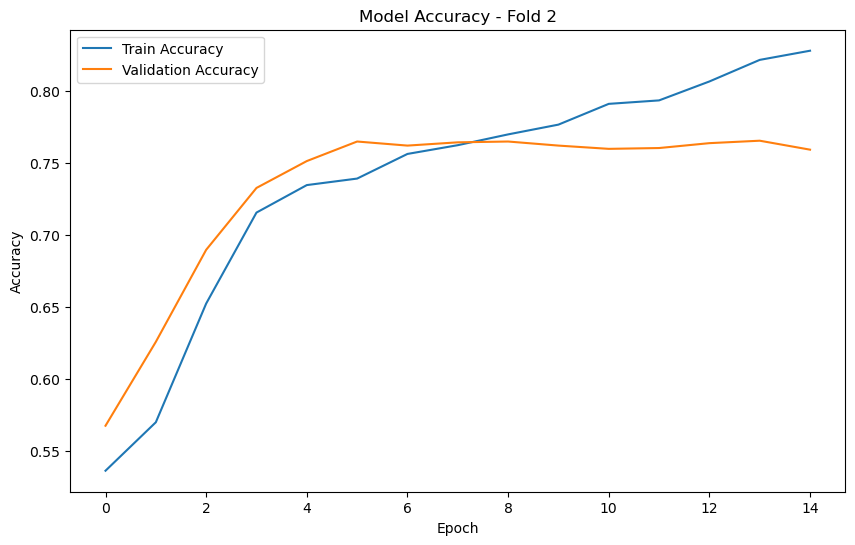

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2 Results:
Accuracy: 0.7621
Balanced Accuracy: 0.7587
MCC: 0.5224
Sensitivity: 0.8184
Specificity: 0.6990

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5229 - loss: 0.7115 - val_accuracy: 0.5746 - val_loss: 0.6814 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5593 - loss: 0.6822 - val_accuracy: 0.5881 - val_loss: 0.6728 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6207 - loss: 0.6553 - val_accuracy: 0.7023 - val_loss: 0.5886 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6973 - loss: 0.5793 - val_accuracy: 0.7260 - val_loss: 0.5625 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7294 - loss: 0.5492 - val_accuracy: 0.7254 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7356 - loss: 0.5327 - val_accuracy: 0.7282 - val_loss: 0.5562 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7478 - loss: 0.5177 - val_

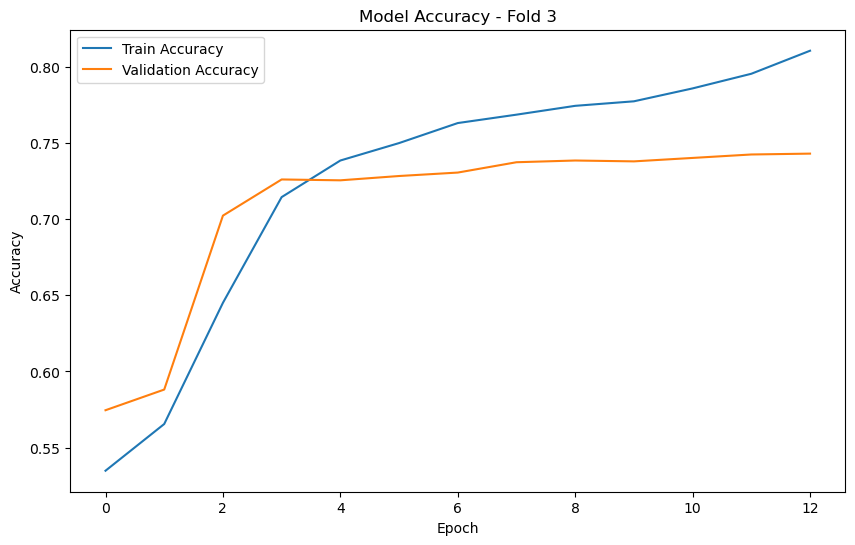

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7373
Balanced Accuracy: 0.7371
MCC: 0.4742
Sensitivity: 0.7426
Specificity: 0.7316

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5507 - loss: 0.7024 - val_accuracy: 0.5927 - val_loss: 0.6744 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5841 - loss: 0.6630 - val_accuracy: 0.6616 - val_loss: 0.6063 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6952 - loss: 0.5836 - val_accuracy: 0.7243 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7322 - loss: 0.5396 - val_accuracy: 0.7418 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7560 - loss: 0.5209 - val_accuracy: 0.7446 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7640 - loss: 0.5023 - val_accuracy: 0.7401 - val_loss: 0.5239 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7743 - loss: 0.4919 - val

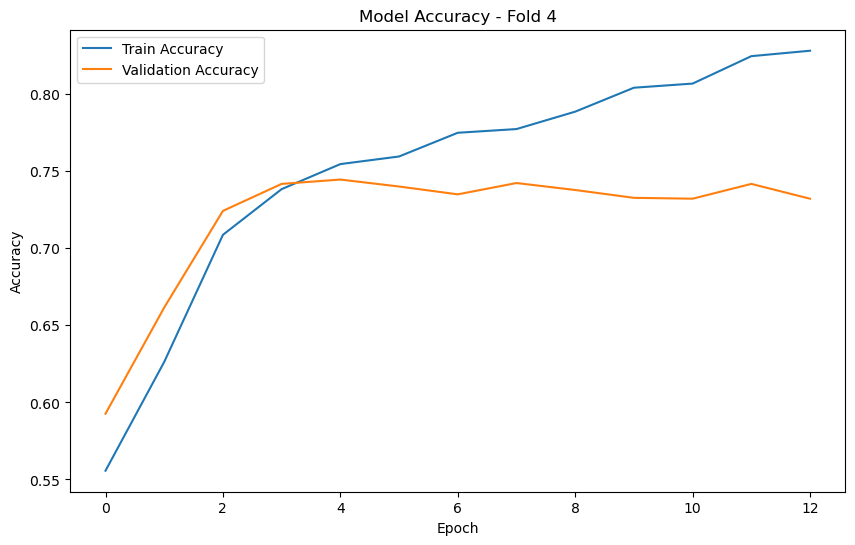

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 4 Results:
Accuracy: 0.7424
Balanced Accuracy: 0.7433
MCC: 0.4867
Sensitivity: 0.7152
Specificity: 0.7713

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5206 - loss: 0.7264 - val_accuracy: 0.5847 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5838 - loss: 0.6739 - val_accuracy: 0.6537 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6622 - loss: 0.6228 - val_accuracy: 0.6921 - val_loss: 0.5845 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7105 - loss: 0.5750 - val_accuracy: 0.7288 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7403 - loss: 0.5334 - val_accuracy: 0.7271 - val_loss: 0.5404 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7571 - loss: 0.5159 - val_accuracy: 0.7390 - val_loss: 0.5277 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7700 - loss: 0.5032 - val

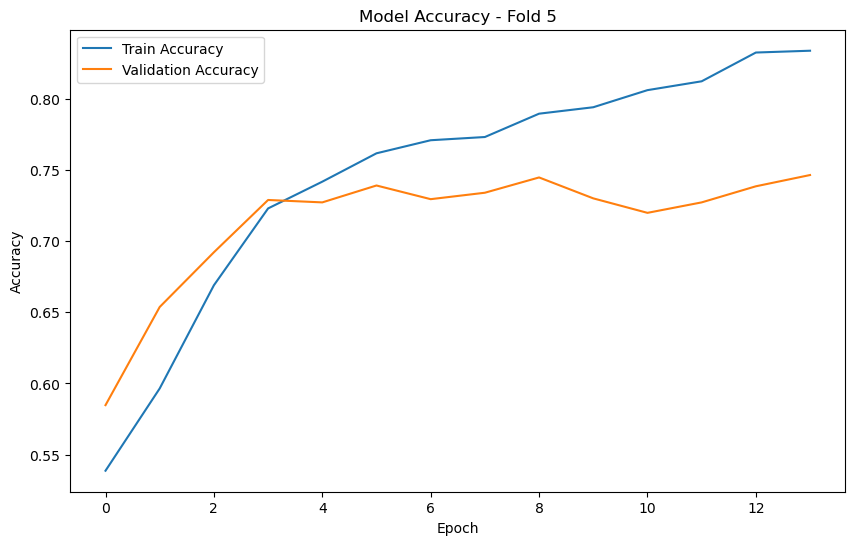

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5 Results:
Accuracy: 0.7446
Balanced Accuracy: 0.7439
MCC: 0.4883
Sensitivity: 0.7634
Specificity: 0.7245

Average Cross-validation Results:
ACC: 0.7475 ± 0.0085
BALANCED_ACC: 0.7464 ± 0.0072
MCC: 0.4948 ± 0.0165
SN: 0.7700 ± 0.0394
SP: 0.7227 ± 0.0292

Final Test Set Results:
Accuracy: 0.7344
Balanced Accuracy: 0.7546
MCC: 0.3102
Sensitivity: 0.7792
Specificity: 0.7301
Confusion Matrix:
[[1823  674]
 [  53  187]]


<Functional name=functional_19, built=True>

In [8]:
train_and_evaluate(struct_window=2)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5257 - loss: 0.7183 - val_accuracy: 0.5678 - val_loss: 0.6802 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5654 - loss: 0.6819 - val_accuracy: 0.5915 - val_loss: 0.6656 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6044 - loss: 0.6584 - val_accuracy: 0.6774 - val_loss: 0.6111 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6711 - loss: 0.6121 - val_accuracy: 0.7277 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7234 - loss: 0.5544 - val_accuracy: 0.7407 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7421 - loss: 0.5261 - val_accuracy: 0.7475 - val_loss: 0.5286 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7650 - loss: 0.5016 - val_

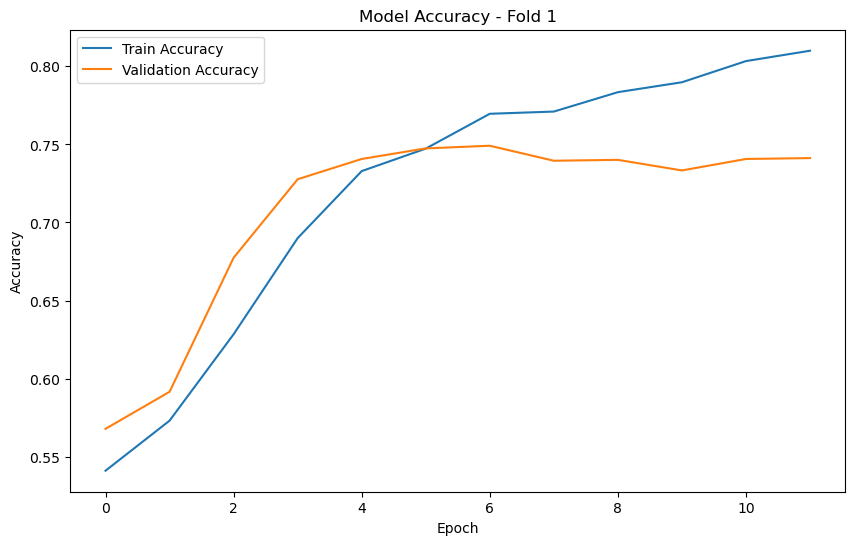

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 1 Results:
Accuracy: 0.7492
Balanced Accuracy: 0.7469
MCC: 0.5000
Sensitivity: 0.8193
Specificity: 0.6744

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5268 - loss: 0.7226 - val_accuracy: 0.5825 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5618 - loss: 0.6793 - val_accuracy: 0.6339 - val_loss: 0.6521 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6134 - loss: 0.6513 - val_accuracy: 0.6588 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6681 - loss: 0.6132 - val_accuracy: 0.6864 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6843 - loss: 0.5907 - val_accuracy: 0.7141 - val_loss: 0.5749 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6990 - loss: 0.5814 - val_accuracy: 0.7169 - val_loss: 0.5624 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7175 - loss: 0.5544 - val_

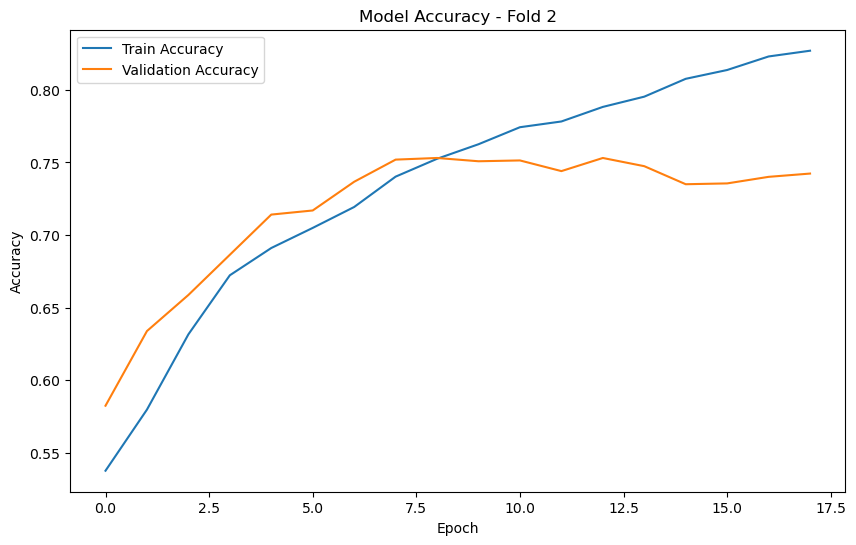

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7531
Balanced Accuracy: 0.7520
MCC: 0.5043
Sensitivity: 0.7714
Specificity: 0.7326

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5294 - loss: 0.7260 - val_accuracy: 0.5469 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5647 - loss: 0.6839 - val_accuracy: 0.6028 - val_loss: 0.6689 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6184 - loss: 0.6495 - val_accuracy: 0.6859 - val_loss: 0.5925 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6962 - loss: 0.5828 - val_accuracy: 0.7215 - val_loss: 0.5565 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7303 - loss: 0.5414 - val_accuracy: 0.7311 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7510 - loss: 0.5210 - val_accuracy: 0.7299 - val_loss: 0.5417 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7475 - loss: 0.5121 - val_

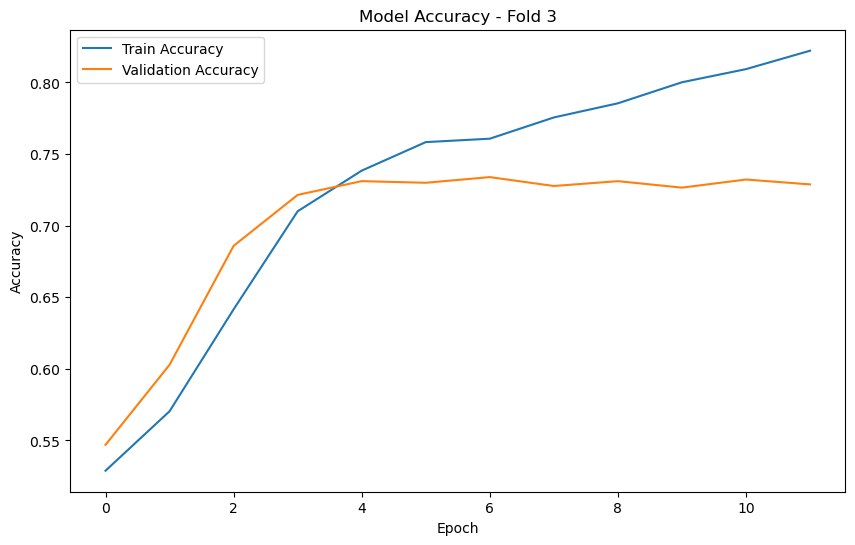

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 3 Results:
Accuracy: 0.7339
Balanced Accuracy: 0.7328
MCC: 0.4670
Sensitivity: 0.7689
Specificity: 0.6966

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5233 - loss: 0.7162 - val_accuracy: 0.5695 - val_loss: 0.6805 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5862 - loss: 0.6733 - val_accuracy: 0.6695 - val_loss: 0.6191 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6845 - loss: 0.5932 - val_accuracy: 0.7124 - val_loss: 0.5707 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7248 - loss: 0.5510 - val_accuracy: 0.7113 - val_loss: 0.5498 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7452 - loss: 0.5271 - val_accuracy: 0.7333 - val_loss: 0.5337 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7588 - loss: 0.5081 - val_accuracy: 0.7356 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7608 - loss: 0.4956 - val_

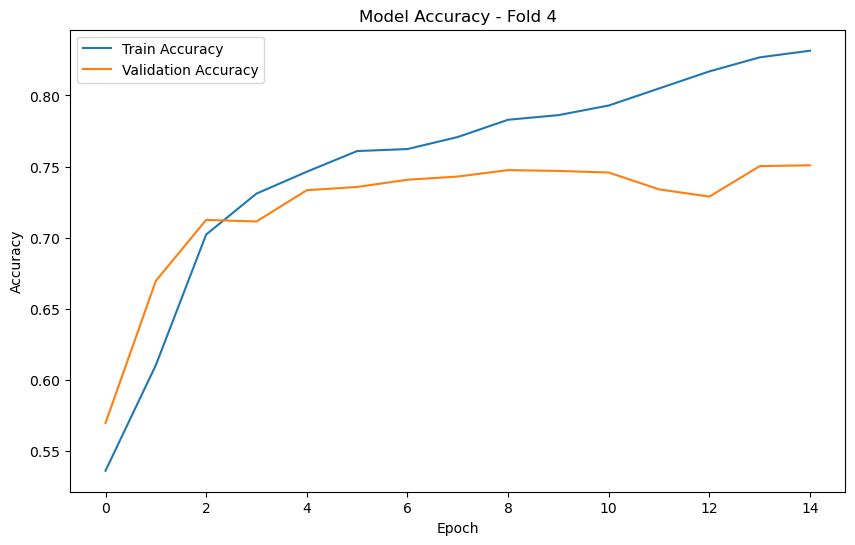

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 4 Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7460
MCC: 0.4930
Sensitivity: 0.7744
Specificity: 0.7176

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5310 - loss: 0.7069 - val_accuracy: 0.5831 - val_loss: 0.6799 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5637 - loss: 0.6754 - val_accuracy: 0.6164 - val_loss: 0.6535 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6385 - loss: 0.6414 - val_accuracy: 0.6667 - val_loss: 0.6074 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6909 - loss: 0.5938 - val_accuracy: 0.6932 - val_loss: 0.5890 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7030 - loss: 0.5668 - val_accuracy: 0.6893 - val_loss: 0.5796 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7277 - loss: 0.5499 - val_accuracy: 0.7169 - val_loss: 0.5593 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7329 - loss: 0.5346 - val_

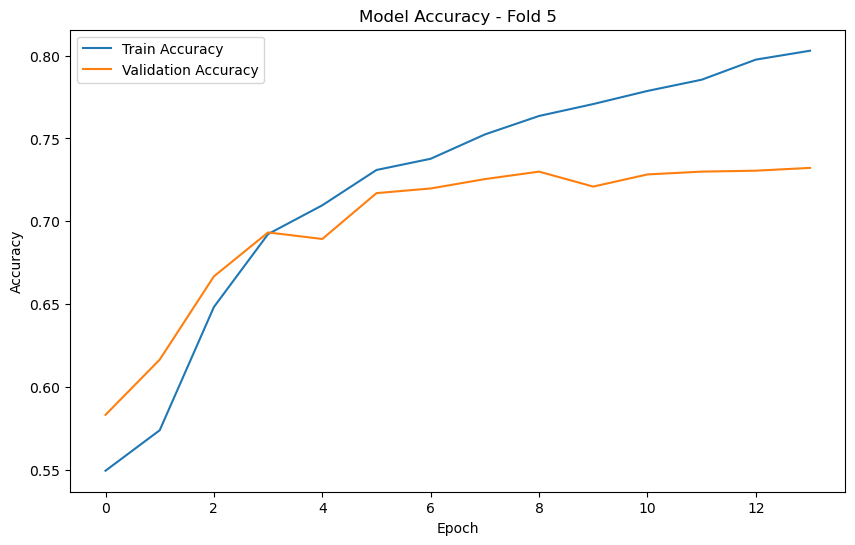

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5 Results:
Accuracy: 0.7299
Balanced Accuracy: 0.7275
MCC: 0.4599
Sensitivity: 0.7939
Specificity: 0.6612

Average Cross-validation Results:
ACC: 0.7426 ± 0.0090
BALANCED_ACC: 0.7410 ± 0.0093
MCC: 0.4849 ± 0.0180
SN: 0.7856 ± 0.0190
SP: 0.6965 ± 0.0264

Final Test Set Results:
Accuracy: 0.7077
Balanced Accuracy: 0.7362
MCC: 0.2821
Sensitivity: 0.7708
Specificity: 0.7016
Confusion Matrix:
[[1752  745]
 [  55  185]]


<Functional name=functional_29, built=True>

In [9]:
train_and_evaluate(struct_window=3)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5127 - loss: 0.7369 - val_accuracy: 0.5333 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5463 - loss: 0.6864 - val_accuracy: 0.5706 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5839 - loss: 0.6734 - val_accuracy: 0.6655 - val_loss: 0.6235 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6566 - loss: 0.6150 - val_accuracy: 0.7271 - val_loss: 0.5712 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7086 - loss: 0.5643 - val_accuracy: 0.7373 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7234 - loss: 0.5454 - val_accuracy: 0.7497 - val_loss: 0.5246 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7560 - loss: 0.5155 - val_

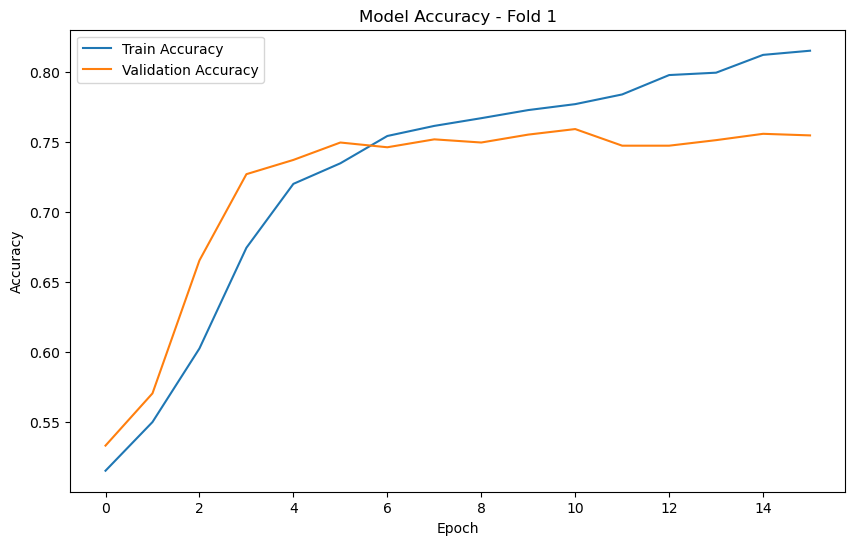

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7593
Balanced Accuracy: 0.7562
MCC: 0.5241
Sensitivity: 0.8543
Specificity: 0.6581

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5073 - loss: 0.7322 - val_accuracy: 0.5520 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5665 - loss: 0.6798 - val_accuracy: 0.5915 - val_loss: 0.6690 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5833 - loss: 0.6684 - val_accuracy: 0.6616 - val_loss: 0.6273 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6581 - loss: 0.6193 - val_accuracy: 0.7040 - val_loss: 0.5755 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7037 - loss: 0.5675 - val_accuracy: 0.7367 - val_loss: 0.5351 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7322 - loss: 0.5362 - val_accuracy: 0.7576 - val_loss: 0.5167 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7476 - loss: 0.5152 - val_

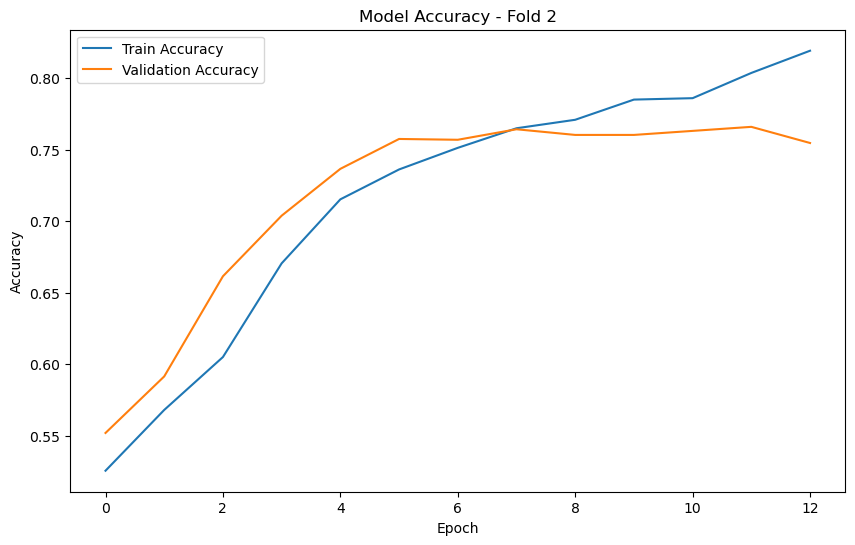

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7644
Balanced Accuracy: 0.7619
MCC: 0.5266
Sensitivity: 0.8056
Specificity: 0.7182

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5205 - loss: 0.7138 - val_accuracy: 0.5672 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5785 - loss: 0.6711 - val_accuracy: 0.6384 - val_loss: 0.6359 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6501 - loss: 0.6282 - val_accuracy: 0.6695 - val_loss: 0.6048 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6872 - loss: 0.5923 - val_accuracy: 0.6972 - val_loss: 0.5764 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7249 - loss: 0.5518 - val_accuracy: 0.7153 - val_loss: 0.5559 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7342 - loss: 0.5373 - val_accuracy: 0.7294 - val_loss: 0.5499 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7429 - loss: 0.5230 - val

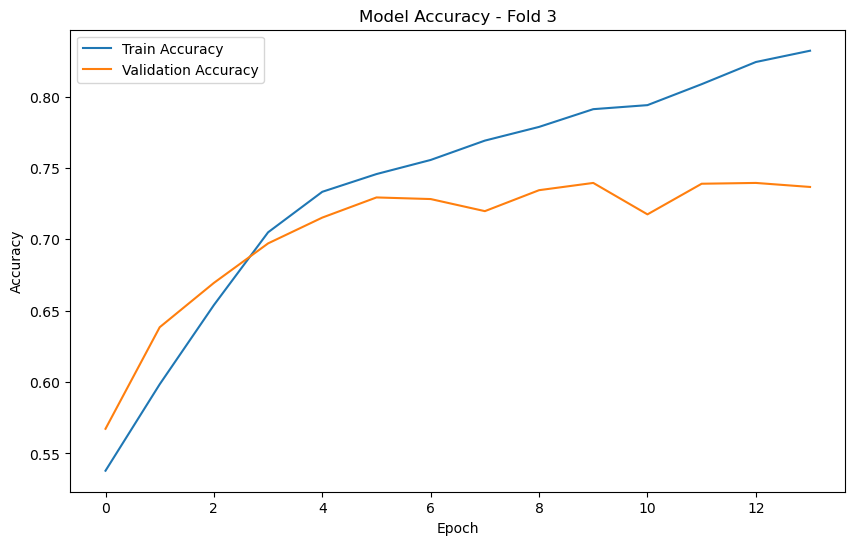

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7345
Balanced Accuracy: 0.7327
MCC: 0.4689
Sensitivity: 0.7886
Specificity: 0.6768

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5154 - loss: 0.7227 - val_accuracy: 0.5847 - val_loss: 0.6799 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5461 - loss: 0.6877 - val_accuracy: 0.6034 - val_loss: 0.6638 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5986 - loss: 0.6591 - val_accuracy: 0.6734 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6645 - loss: 0.6175 - val_accuracy: 0.6972 - val_loss: 0.5951 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6994 - loss: 0.5763 - val_accuracy: 0.7147 - val_loss: 0.5619 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7258 - loss: 0.5448 - val_accuracy: 0.7384 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7452 - loss: 0.5159 - val

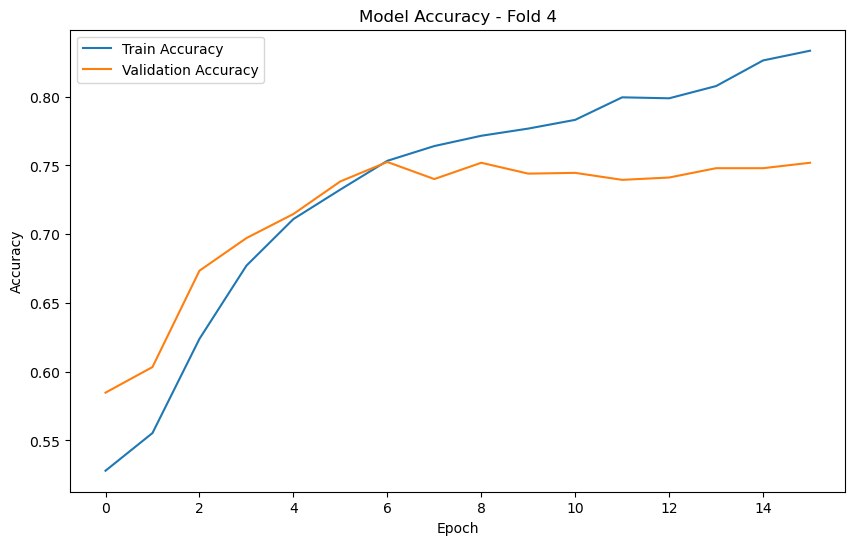

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Results:
Accuracy: 0.7446
Balanced Accuracy: 0.7443
MCC: 0.4887
Sensitivity: 0.7547
Specificity: 0.7340

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.5349 - loss: 0.7089 - val_accuracy: 0.6130 - val_loss: 0.6708 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6094 - loss: 0.6469 - val_accuracy: 0.6915 - val_loss: 0.5883 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6971 - loss: 0.5874 - val_accuracy: 0.7056 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7253 - loss: 0.5466 - val_accuracy: 0.7175 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7381 - loss: 0.5267 - val_accuracy: 0.7277 - val_loss: 0.5328 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7498 - loss: 0.5069 - val_accuracy: 0.7271 - val_loss: 0.5376 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7676 - loss: 0.4889 - val

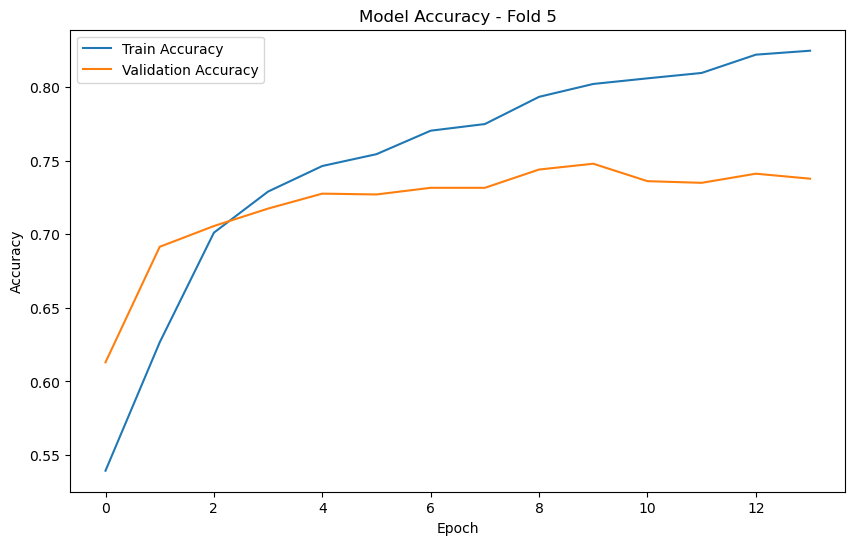

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5 Results:
Accuracy: 0.7441
Balanced Accuracy: 0.7431
MCC: 0.4871
Sensitivity: 0.7699
Specificity: 0.7163

Average Cross-validation Results:
ACC: 0.7494 ± 0.0109
BALANCED_ACC: 0.7476 ± 0.0103
MCC: 0.4991 ± 0.0226
SN: 0.7946 ± 0.0344
SP: 0.7007 ± 0.0284

Final Test Set Results:
Accuracy: 0.7030
Balanced Accuracy: 0.7355
MCC: 0.2802
Sensitivity: 0.7750
Specificity: 0.6960
Confusion Matrix:
[[1738  759]
 [  54  186]]


<Functional name=functional_39, built=True>

In [10]:
train_and_evaluate(struct_window=4)